In [7]:
from PatientDataset import group_split_df, transforms, PatientDS, get_df
from Train import train, plot_train_hist, set_seed_mps, patient_multiclass_collate, get_sampler
from Evaluate_multiclass import evaluate
from Models_MIL_embed import ResNet50_embed, Attention_Pool, PatientCNNClassifier
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

## Patient Level Classifier
Uses multi-head self-attention and then an MIL attention-based pooling (with or without gating).

#### 4 Dimensional 1-hot prediction

In [13]:
# Load and Preprocess Data
train_transform, val_transform, test_transform = transforms(img_size=224)

train_ds = PatientDS(train_transform, image_path = 'train/2020_jpg', use_meta=True, upsampling = False, mode='Train', saving_images=False)
val_ds = PatientDS(val_transform, image_path = 'train/2020_jpg', use_meta=False, mode='val', saving_images=False)
test_ds = PatientDS(test_transform, image_path = 'train/2020_jpg', use_meta=False, mode='test', upsampling = False, saving_images=False)

# sampler, pos_w = get_sampler(train_ds)
sampler, pos_w = get_sampler(test_ds, oversample_ratio = 1.7)


# train_dl = DataLoader(train_ds, batch_size=1,  sampler=sampler, shuffle = False, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=1,  sampler=None,  shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1,  sampler=None, shuffle=False, num_workers=0)

In [ ]:
# Set up Model
# criterion = nn.BCEWithLogitsLoss() # without weighted loss
for weights in [1, 4, 10, 20]:
    net = PatientCNNClassifier(num_heads = 2, attention_type = 'gated')
    net.to('mps')
    net.squeeze = True
    pos_weight = torch.tensor([weights*1.5, weights*0.5, weights*0.5, weights*0.5], device='mps', dtype = torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight= pos_weight) # with weighted loss
    opt = torch.optim.AdamW([
        {"params": net.attention.parameters(), "lr": 1e-3},
        {"params": net.resnet.backbone.layer4.parameters(), "lr": 1e-5},
        {"params": net.resnet.head.parameters(), "lr": 1e-4}
    ])

    # Train only the last layers (freeze the backbone)
    for p in net.attention.parameters():
        p.requires_grad = True
    for p in net.resnet.parameters():
        p.requires_grad = False
    for p in net.resnet.backbone.layer4.parameters():
        p.requires_grad = True
    for p in net.resnet.head.parameters():
        p.requires_grad = True

    hist_train_loss_res, hist_val_loss_res, hist_val_acc_res = train(net, test_dl, val_dl, criterion, opt,
                                                         epochs = 1, best_model_name = "gatedattentionpool_2heads_4classes.pt")

  1%|          | 2/206 [00:06<09:08,  2.69s/it]

In [3]:
# Load Saved Model
net = PatientCNNClassifier(num_heads = 2, attention_type = 'gated')
net.to('mps')
state_dict = torch.load("gatedattentionpool_2heads_4classes.pt", map_location='mps')
net.load_state_dict(state_dict)

acc, per_class_acc, auc_per_class, ys, ps  = evaluate(net, test_dl, device = 'mps', use_meta= True, threshold=0.5)

100%|██████████| 206/206 [02:55<00:00,  1.17it/s]

MEL: AUC=0.7344  ACC=0.6905
[[516 153]
 [102  53]] 



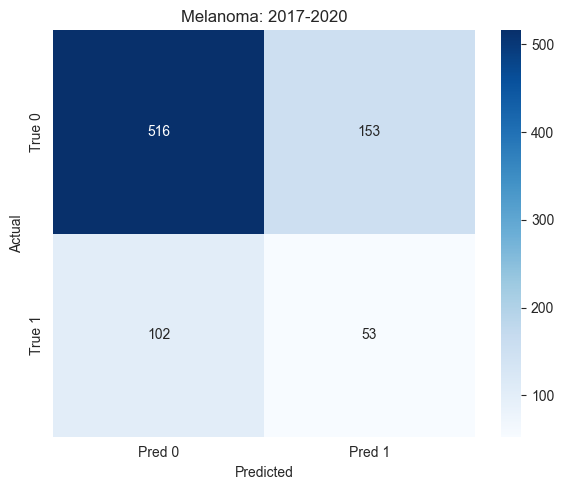

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cm = np.array([[516 , 153],
 [102 , 53]]  )

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])

plt.title("Melanoma: 2017-2020")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#### 1 Dimensional Binary Prediction

In [5]:
# Load and Preprocess Data
train_transform, val_transform, test_transform = transforms(img_size=224)

train_ds = PatientDS(train_transform, image_path = 'train/2020_jpg', diagnosis = False, use_meta=True, upsampling = True, mode='Train', saving_images=False)
val_ds = PatientDS(val_transform, image_path = 'train/2020_jpg', diagnosis = False, use_meta=False, mode='val', saving_images=False)
test_ds = PatientDS(test_transform, image_path = 'train/2020_jpg', diagnosis = False, use_meta=False, mode='test', upsampling = False, saving_images=False)

sampler, pos_w = get_sampler(train_ds)

train_dl = DataLoader(train_ds, batch_size=1,  sampler= sampler , shuffle = False, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=1,  sampler=None,  shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1,  sampler=None, shuffle=False, num_workers=0)

In [6]:
xb, yb, mb = next(iter(train_dl))
xb = xb.to('mps').squeeze(0)
yb = yb.to('mps').squeeze(0)
mb = mb.to('mps').squeeze(0)
net = PatientCNNClassifier(num_heads = 1, new_embed = 1, attention_type = 'gated', pool_branches = 1)
net.to('mps')
net.train()
logits = net(xb, mb)
logits.shape

torch.Size([1])

In [9]:
# Set up Model
# criterion = nn.BCEWithLogitsLoss() # without weighted loss
net = PatientCNNClassifier(num_heads = 1, new_embed = 1, attention_type = 'gated', pool_branches = 1)
net.to('mps')
net.squeeze = True # gives a 1D output during validation
# pos_weight = torch.tensor([57*0.4, 1, 1, 1], device='mps', dtype = torch.float32)
pos_weight = torch.tensor([1], device='mps', dtype = torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight= pos_weight) # with weighted loss
opt = torch.optim.AdamW([
    {"params": net.attention.parameters(), "lr": 1e-3},
    {"params": net.resnet.backbone.layer4.parameters(), "lr": 1e-5},
    {"params": net.resnet.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.attention.parameters():
    p.requires_grad = True
for p in net.resnet.parameters():
    p.requires_grad = False
for p in net.resnet.backbone.layer4.parameters():
    p.requires_grad = True
for p in net.resnet.head.parameters():
    p.requires_grad = True

hist_train_loss_res, hist_val_loss_res, hist_val_acc_res = train(net, train_dl, val_dl, criterion, opt,
                                                     epochs = 1, best_model_name = "testing.pt")

100%|██████████| 1644/1644 [1:58:17<00:00,  4.32s/it]  


Epoch 1: Val ACC = 0.9757281553398058 Loss Ratio=0.6381, Val MEL AUC=0.5000, Val MEL Pos Acc=0.0000
Best validation pos_acc: 0.0000


In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cm = np.array([[516 , 153],
 [102 , 53]]  )

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])

plt.title("Melanoma: 2017-2020")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()